In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, SystemMessage,HumanMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [7]:
from langchain_groq import ChatGroq

model = ChatGroq(model="Gemma2-9b-It", temperature=0.7)

In [8]:
from langgraph.graph import StateGraph, START, END
def make_blog_generation_graph():
    """Create a blog generation agent"""
    graph_workflow = StateGraph(State)

    
    # Step 1: Generate title based on the topic
    def generate_title(state):
        prompt_1 = SystemMessage(content="As an experienced writer generate one blog title.")
        return {"messages":[model.invoke([prompt_1] + state["messages"])]}

    # Step 2: Generate content based on the title
    def generate_content(state):
        prompt_2 = SystemMessage(content="As an experienced content creator write a blog with 500 word limit in 4 paragraphs.")
        return {"messages":[model.invoke([prompt_2] + state["messages"])]}

    # Add nodes to the graph
    graph_workflow.add_node("title_generation", generate_title)
    graph_workflow.add_node("content_generation", generate_content)
    
    # Define graph edges
    graph_workflow.add_edge("title_generation", "content_generation")
    graph_workflow.add_edge("content_generation", END)
    graph_workflow.add_edge(START, "title_generation")

    # Compile the graph into an executable agent
    agent = graph_workflow.compile()
    
    return agent

In [9]:
if __name__ == "__main__":
    # Initialize the blog generation agent
    blog_agent = make_blog_generation_graph()

    # initialized initial state
    initial_state = State(
        messages=[HumanMessage(content="Generative AI")]
    )
    response = blog_agent.invoke(initial_state) 
    
    for output in blog_agent.stream(initial_state):
        for key, value in output.items():
            print(f"Output from node: {key}")
            print("------")
            print(value['messages'][0].content)
            print("\n------\n")

    for message in response["messages"]:
        print(message.content)

Output from node: title_generation
------
##  Can Generative AI Write a Bestseller?  Exploring the Future of Storytelling 


------

Output from node: content_generation
------
 
Generative AI is rapidly changing the landscape of creative industries, and the world of storytelling is no exception. This powerful technology, capable of crafting text, images, music, and even code, raises fascinating questions about the future of authorship and the very nature of creativity. While some fear AI will replace human writers, others see it as a revolutionary tool, empowering creators to explore new frontiers.  

Currently, generative AI excels at mimicking existing styles and generating coherent text based on prompts.  ChatGPT, Dall-E, and other AI models can churn out poems, scripts, articles, and even novel-length stories.  However, these creations often lack the depth, nuance, and emotional resonance that come from lived experience and genuine human insight. AI can mimic the mechanics of stor

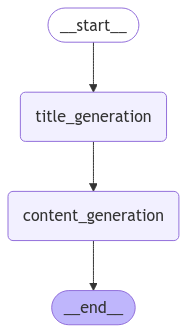

In [10]:
blog_agent